In [1]:
#DATA_PATH = 'C:/Users/amityu/Gel_Sheet_Data/'
DATA_PATH ='D:/amityu/backoffice_data/'
import matplotlib.pyplot as plt
from analysis import autocorrelation_and_structure_factor_IK_and_YA as ac
from utils import  graph_utils as gu
from matplotlib.ticker import FormatStrFormatter
from matplotlib.animation import FuncAnimation
import pandas as pd
from tqdm.notebook import trange, tqdm
import numpy as np
import json
import importlib
from numpy.fft import fft2, fftshift,ifftshift
from analysis import curvature_exec as curv
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from skimage.feature import blob_log
from sklearn.neighbors import KDTree
from utils import analysis_utils
import matplotlib.colors as colors

mu_symbol = "\u03BC"

In [2]:
movie_list = ['Control', '140721', '150721', '100621', '130721_CCA60_RAW','280523 AM100 568_1', 'control_1_050721','cca120', 'cca120_am200']

for i, m in enumerate(movie_list):
    print(i,m)


0 Control
1 140721
2 150721
3 100621
4 130721_CCA60_RAW
5 280523 AM100 568_1
6 control_1_050721
7 cca120
8 cca120_am200


In [3]:
k = 4
movie= movie_list[k]
MOVIE_PATH = DATA_PATH +  movie + '/'
GRAPH_PATH = 'C:/Users/amityu/Gel_Sheet_Graph/'
ADD_DATA_PATH = 'C:/Users/amityu/DataspellProjects/gel_sheets/add_data/%s/'%movie
with open(MOVIE_PATH + 'ex_data.json', 'r') as f:
    ex_data = json.load(f)
print('movie {}'.format(movie))


movie 130721_CCA60_RAW


In [4]:
surface = np.load(MOVIE_PATH + 'np/height.npy')

### finding local maximum

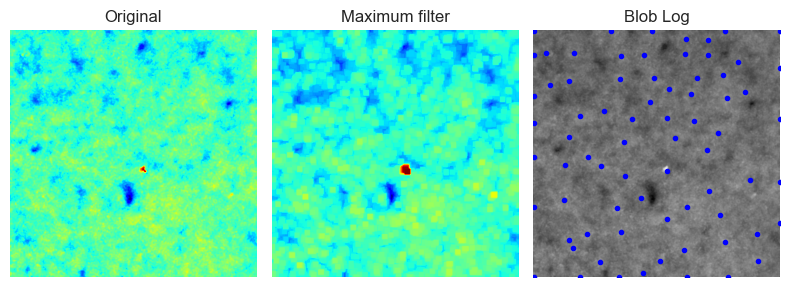

In [62]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float
from skimage.feature import blob_log
from sklearn.neighbors import KDTree
img = surface[5].copy()

im = img_as_float(img)

image_max = ndi.maximum_filter(im, size=10, mode='constant')

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = blob_log(image_max, min_sigma=15)

# display results
fig, axes = plt.subplots(1, 3, figsize=(8, 3), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(im, cmap='jet')
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap='jet')
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'b.')
ax[2].axis('off')
ax[2].set_title('Blob Log')

fig.tight_layout()

plt.show()

## Blob log visualization

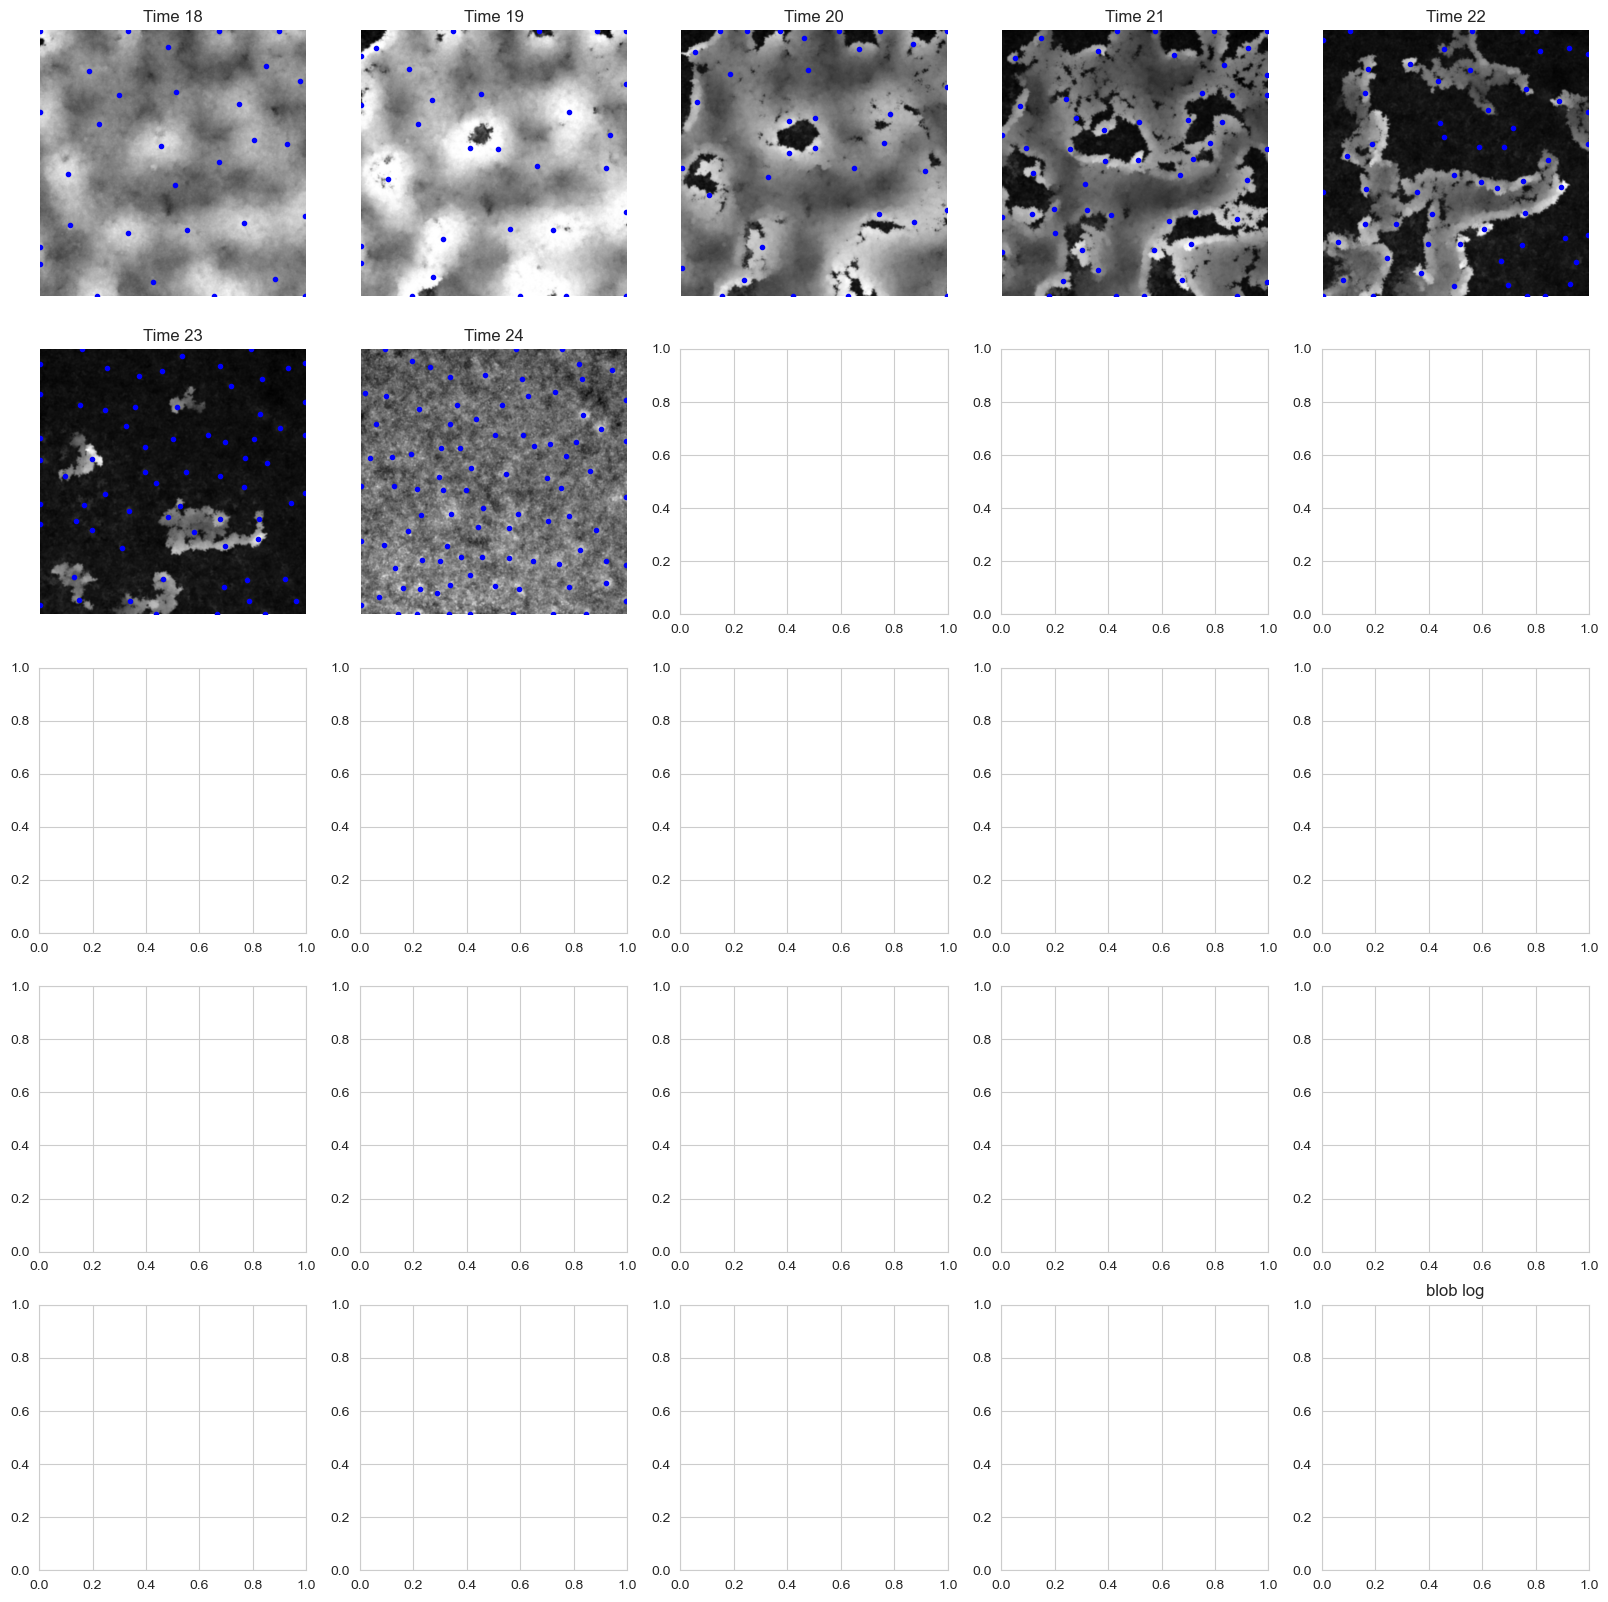

In [88]:
T =range(18, 25,1)
fig, ax = plt.subplots(5,5,figsize=(20,20))
ax = ax.ravel()
plt.title('blob log')

for i,t in enumerate(T):
    img = surface[t].copy()

    im = img_as_float(img)

    # image_max is the dilation of im with a 20*20 structuring element
    # It is used within peak_local_max function
    image_max = ndi.maximum_filter(im, size=10, mode='constant')

    # Comparison between image_max and im to find the coordinates of local maxima
    #coordinates = peak_local_max(image_max, min_distance=15)
    coordinates = blob_log(image_max, min_sigma=15, max_sigma=40)
    ax[i].imshow(im, cmap=plt.cm.gray)
    ax[i].autoscale(False)
    ax[i].plot(coordinates[:, 1], coordinates[:, 0], 'b.')
    ax[i].axis('off')
    ax[i].set_title('Time {}'.format(t))
plt.show()

In [7]:
T =range(0, len(surface),1)
peak_number = np.zeros(len(T))
nearest_neoghbour_dist = np.zeros_like(peak_number)
curvature= np.zeros_like((peak_number))
relative_height = np.zeros_like(peak_number)
tree_list = []
coordinates_list = []
indices_list = []
#vmin = np.nanmin([np.nanmin(surface[t]) for t in T])
#vmax = np.nanmax([np.nanmax(surface[t]) for t in T])

for i,t in enumerate(T):
    img = surface[t].copy()

    im = img_as_float(img)

    # image_max is the dilation of im with a 20*20 structuring element
    # It is used within peak_local_max function
    image_max = ndi.maximum_filter(im, size=10, mode='constant')

    # Comparison between image_max and im to find the coordinates of local maxima
    #coordinates = peak_local_max(image_max, min_distance=15)
    coordinates= coordinates_list[i]
    peak_number[i] = len(coordinates)
    points = coordinates[:,:2]
    tree = KDTree(points)
    tree_list.append(tree)
    dist, ind = tree.query(points[:10],2)
    indices_list.append(ind)
    nearest_neoghbour_dist[i] = np.mean(dist[:,1])
    curvature_t = np.zeros(len(points))
    surface_curvature= curv.gaussian_curvature(surface[t], sigma=5)
    relative_height_t = np.zeros(len(points))
    for j, (x,y) in enumerate(points):
        curvature_t[j] = surface_curvature[int(x),int(y)]
        relative_height_t[j] = surface[t, int(x),int(y)] - np.nanmean(surface[t])
    curvature[i] = np.nanmean(curvature_t)
    relative_height[i] = np.nanmean(relative_height_t)


## neighbours distance 

In [ ]:
coordinates_list = analysis_utils.blob_log_coordinates(surface, min_sigma=15, max_sigma=40)



In [9]:
nearest_neoghbour_dist = np.zeros(len(coordinates_list))
nearest_neoghbour_std = np.zeros(len(coordinates_list))

for i in range(1, len(coordinates_list)):
    tree = tree_list[i]
    prev_tree = tree_list[i-1]
    coordinates = coordinates_list[i-1]
    
    dist, ind = tree.query(coordinates[:,0:2],1)
    nearest_neoghbour_dist[i] = np.mean(dist[:,0])
    nearest_neoghbour_std[i] = np.nanstd(dist[:,0])


In [17]:
dist[:,0]

array([ 2.        ,  1.41421356,  2.23606798,  2.23606798,  1.        ,
        3.60555128,  1.41421356,  2.23606798,  3.        ,  4.        ,
        2.        ,  2.        ,  5.83095189,  8.94427191,  4.47213595,
       18.60107524,  3.        ,  3.16227766, 26.40075756,  5.        ,
        7.21110255, 12.36931688, 22.47220505,  1.        ,  1.41421356,
        1.41421356,  5.        ,  7.07106781,  4.        ,  3.16227766,
        4.        ,  9.05538514, 12.08304597,  4.12310563, 15.8113883 ,
        9.        ,  6.        ,  2.82842712, 14.03566885,  3.16227766,
        2.        ,  1.41421356, 22.47220505,  9.05538514, 10.        ,
        9.8488578 , 11.18033989, 11.        ,  7.21110255,  5.65685425,
        0.        ,  1.        , 12.80624847, 47.01063709, 22.        ,
       27.        ,  7.28010989, 15.5241747 ,  3.16227766,  6.        ,
        4.47213595,  5.83095189,  5.09901951, 19.31320792, 29.42787794,
       28.        , 49.92995093,  1.        , 22.8035085 , 21.26

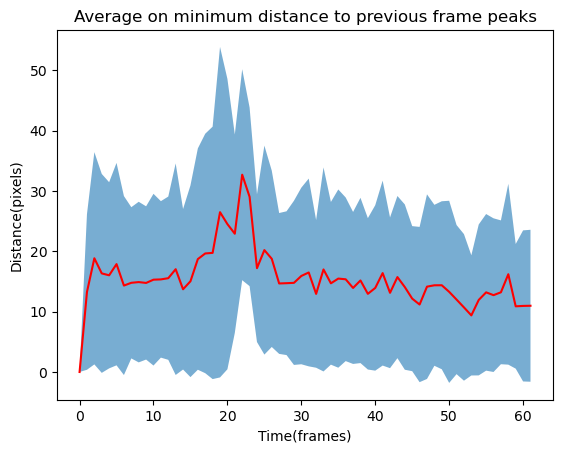

In [11]:
plt.plot(nearest_neoghbour_dist, color = 'red')
plt.fill_between(range(len(nearest_neoghbour_dist)), nearest_neoghbour_dist - nearest_neoghbour_std, nearest_neoghbour_dist + nearest_neoghbour_std, alpha = 0.6)
plt.xlabel('Time(frames)')
plt.ylabel('Distance(pixels)')
plt.title('Average on minimum distance to previous frame peaks')
plt.show()

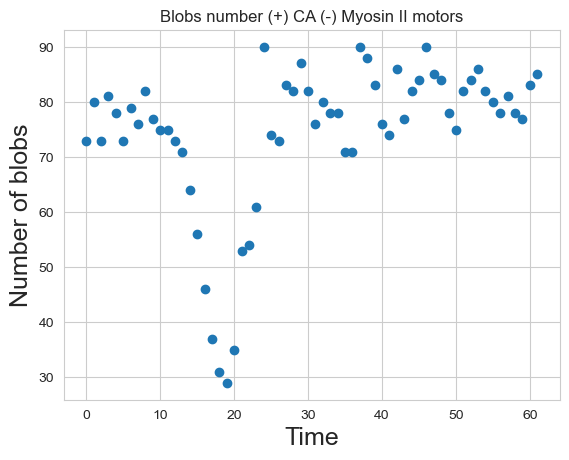

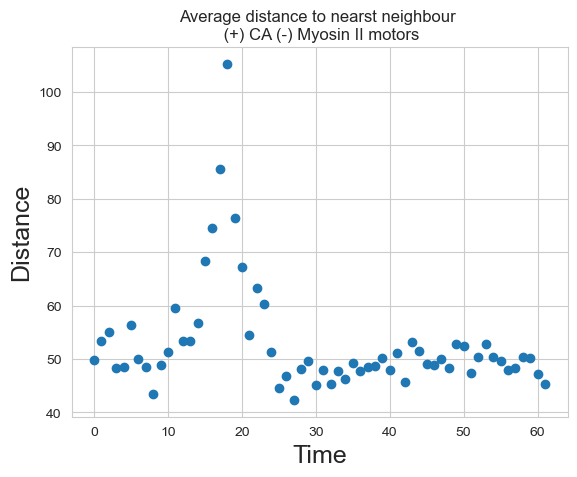

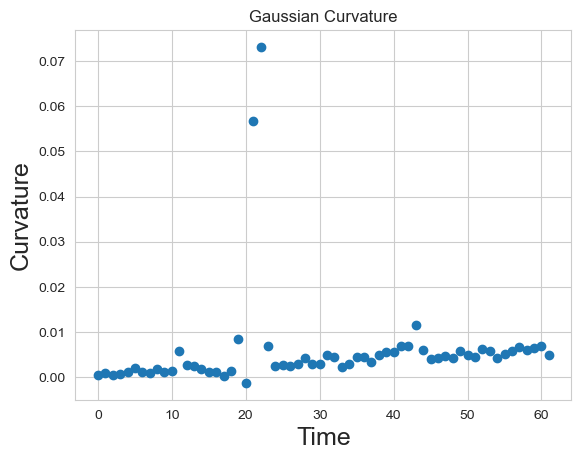

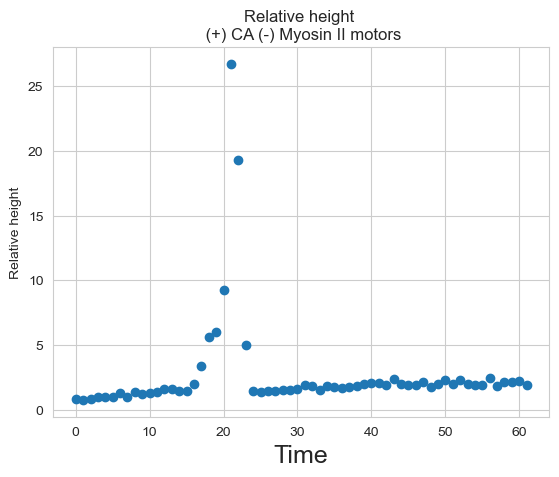

In [83]:
plt.scatter(range(len(peak_number)),peak_number)
plt.title('Blobs number %s'%ex_data['name'])
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Number of blobs', fontsize = 18)
plt.show()
plt.scatter(range(len(nearest_neoghbour_dist)),nearest_neoghbour_dist)
plt.title('Average distance to nearst neighbour \n %s'%ex_data['name'])
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Distance', fontsize = 18)

plt.show()
plt.scatter(range(len(curvature)),curvature)
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Curvature', fontsize = 18)
plt.title('Gaussian Curvature')
plt.show()

plt.scatter(range(len(relative_height)), relative_height)
plt.xlabel('Time', fontsize = 18)
plt.ylabel('Relative height')
plt.title('Relative height \n %s'%ex_data['name'])
plt.show()

### <span color='red'> 3d Animation with blob marking

In [ ]:

#set variables
import json

surface = np.load(MOVIE_PATH + 'np/height.npy')
# Open the file and load the data
with open(MOVIE_PATH + 'ex_data.json', 'r') as f:
    ex_data = json.load(f)

spike_time_range = range(18, 25)
spike = np.load(MOVIE_PATH + 'np/spike.npy')
surface = np.load(MOVIE_PATH + 'np/height.npy')
surface[spike_time_range] = spike[spike_time_range]
time_df = pd.read_csv(ADD_DATA_PATH + '%s_time.csv' % movie)

sigma = 3  # gaussian filter with sigma
_ = gu.interpolate_smooth_restore_3d(surface, sigma)
execute = False
if execute:
    surface[:, 0:80, :] = np.nan
    surface[:, :, 0:50] = np.nan
from mpl_toolkits.mplot3d import Axes3D


In [17]:
coordinates_list = analysis_utils.blob_log_coordinates(surface, min_sigma=15, max_sigma=40)

  0%|          | 0/62 [00:00<?, ?it/s]

Exception ignored in: <function WeakMethod.__new__.<locals>._cb at 0x0000021E272D9990>
Traceback (most recent call last):
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\weakref.py", line 61, in _cb
    callback(self)
  File "C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\matplotlib\cbook.py", line 248, in _remove_proxy
    del self.callbacks[signal][cid]
KeyError: 'changed'


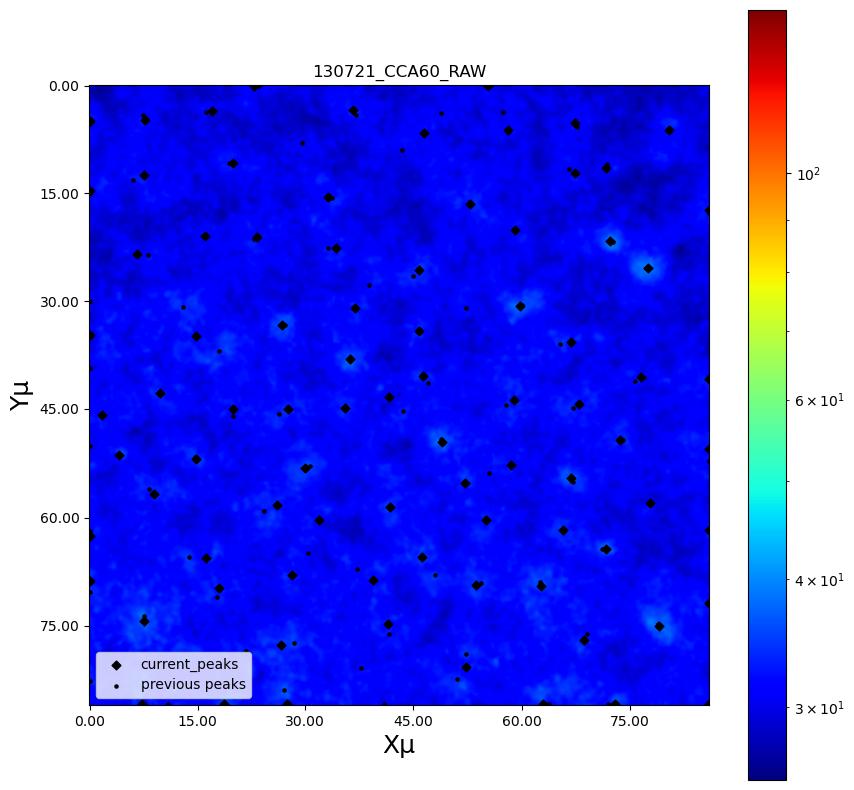

In [14]:


colormap = 'jet'

xx = np.arange(0, surface.shape[1])
yy = np.arange(0, surface.shape[2])
X, Y = np.meshgrid(xx, yy)

v_min = np.nanmin(surface)
v_max = np.nanmax(surface)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)#, projection='3d')
norm = colors.LogNorm(vmin=v_min, vmax=v_max)

cax= ax.imshow(surface[0], cmap=colormap, norm=norm)
fig.colorbar(cax)

#time_range = np.arange(0, 3, 0.25)
time_range = np.arange(1, len(surface), 0.25)


formatter = FormatStrFormatter('%.2f')  # Two decimal places


def update(t):
    if t == int(t):
        t = int(t)
        ax.clear()
        #ax.scatter(t*2%512, t*3%512,t*6%512 , 'o', s = 20, color = 'r' )
        img = surface[int(t)].copy()

        im = img_as_float(img)

        # image_max is the dilation of im with a 20*20 structuring element
        # It is used within peak_local_max function
        image_max = ndi.maximum_filter(im, size=10, mode='constant')

        # Comparison between image_max and im to find the coordinates of local maxima
        #coordinates = peak_local_max(image_max, min_distance=15)
        coordinates = coordinates_list[t]
        #ax.scatter(coordinates[:,0], coordinates[:,1], surface[t, coordinates[:,0].astype(int), coordinates[:,1].astype(int)]+12 , s = 20, color= 'black', marker='D')
        ax.scatter(coordinates[:,1], coordinates[:,0],  s = 20, color= 'Black', marker='D', label= 'current_peaks')

        coordinates_prev = coordinates_list[t-1]
        #ax.scatter(coordinates[:,0], coordinates[:,1], surface[t, coordinates[:,0].astype(int), coordinates[:,1].astype(int)]+12 , s = 20, color= 'black', marker='D')
        ax.scatter(coordinates_prev[:,1], coordinates_prev[:,0],  s = 20, color= 'black', marker='.', label='previous peaks')
        #for i in range(len(coordinates_list[t])):
        #    plt.plot([coordinates_list[t][i][0], coordinates_list[t-1][indices_list[t][0]]], [coordinates_list[t][i][1], coordinates_list[t-1][indices_list[t][1]]])
        frame_time = int(time_df.loc[time_df['frame'] == t, 'time (sec)'].values[0])

        ax.set_title('Top surface %s \n Time = %s (sec)' % (ex_data['name'], frame_time), fontsize=18)
        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        #ax.zaxis.set_major_formatter(formatter)

        ax.xaxis.set_major_formatter(formatter)
        ax.yaxis.set_major_formatter(formatter)
        #ax.zaxis.set_major_formatter(formatter)

        cax= ax.imshow(surface[t], cmap=colormap, norm=norm)
        
        #ax.set_zlim(v_min, v_max)
        x_labels = np.arange(0, int(surface.shape[1] * ex_data['delta x']), 15)
        x_ticks = (x_labels / ex_data['delta x']).astype(int)
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(['%.2f' % j for j in x_labels])
        ax.set_yticks(x_ticks)
        ax.set_yticklabels(['%.2f' % j for j in x_labels])
       

        ax.set_xlabel('X\u03BC', fontsize=18)
        ax.set_ylabel('Y\u03BC', fontsize=18)
        plt.title(movie)
        plt.legend()

animation = FuncAnimation(fig, update, frames=time_range[1:], repeat=False, interval=1000)  # 1 second per frame

# Save the animation as an MPEG file
animation.save(GRAPH_PATH + '3d/3d_%s.avi' % movie, writer='ffmpeg', extra_args=['-crf', '8'], codec='h264', fps=4)
#update(16)
# Display the animation (optional)
plt.show()


##<span color='red'> Radial Distribution Function

In [5]:
coordinates_list = analysis_utils.blob_log_coordinates(surface, min_sigma=15, max_sigma=40)


  0%|          | 0/62 [00:00<?, ?it/s]

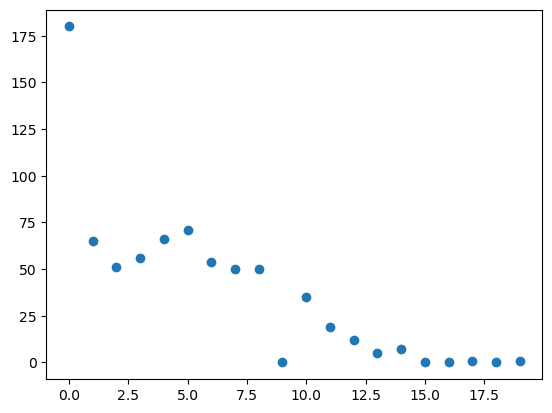

In [37]:
radial_distance = np.zeros(int(np.sqrt(surface.shape[1]**2 + surface.shape[2]**2)))
bin_width = 35
bins = int(len(radial_distance)/bin_width)

t = 40
tree = KDTree(coordinates_list[t][:,:2])
dist, ind = tree.query(coordinates_list[t][:,0:2],len(coordinates_list[t]))
dist = dist.astype(int)
for distance_line in dist:
    for d in distance_line:
        radial_distance[d] +=1
        
    
radial_plot = np.histogram(radial_distance[1:], bins = bins)
plt.scatter(range(bins),radial_plot[0])
plt.show()

In [14]:
len(radial_distance)

724